# 🚀 Глубокое погружение в Stacking и Blending

## 🎯 Цели исследования
Изучить и сравнить продвинутые ensemble методы - stacking и blending, которые являются одними из самых мощных техник комбинирования моделей в машинном обучении.

## 📚 Что изучим:
1. **Теория ensemble методов** - математические основы и интуиция
2. **Stacking (Stacked Generalization):**
   - **Multi-level Stacking** - многоуровневые архитектуры
   - **Cross-validation Stacking** - предотвращение переобучения
   - **Feature-aware Stacking** - использование исходных признаков
   - **Dynamic Stacking** - адаптивное комбинирование
3. **Blending методы:**
   - **Simple Blending** - простое усреднение
   - **Weighted Blending** - взвешенное комбинирование
   - **Rank Blending** - комбинирование на основе рангов
   - **Bayesian Model Averaging** - байесовское усреднение
4. **Продвинутые техники** и оптимизация
5. **Интерпретируемость** ensemble моделей
6. **Сравнение производительности** и практические рекомендации

## 🔬 Методология:
- Используем датасет Heart Disease для сравнимости с градиентным бустингом
- Реализация различных архитектур stacking и blending
- Оптимизация гиперпараметров с Optuna
- Комплексная оценка производительности
- Практические insights для продакшена

## 💡 Зачем изучать ensemble методы?
- **Золотой стандарт** в Kaggle соревнованиях
- **Снижение переобучения** через diversity
- **Повышение устойчивости** предсказаний
- **Комбинирование сильных сторон** разных алгоритмов
- **State-of-the-art результаты** на многих задачах


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import combinations

# Стандартные библиотеки для ML
from sklearn.model_selection import (train_test_split, cross_val_score, StratifiedKFold, 
                                   cross_val_predict, KFold)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve, log_loss)

# Базовые модели для ensemble
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neural_network import MLPClassifier  # Убрано из исследования
from sklearn.tree import DecisionTreeClassifier

# Gradient Boosting модели
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Ensemble методы
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier

# Оптимизация гиперпараметров
import optuna
from optuna.samplers import TPESampler

# Интерпретируемость
import shap

# Дополнительные инструменты
import time
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import rankdata

# Настройки визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("✅ Все библиотеки успешно импортированы!")
print("📦 Убедитесь, что установлены: pip install xgboost lightgbm catboost shap optuna")
print(f"🔧 Версии:")
print(f"   XGBoost: {xgb.__version__}")
print(f"   LightGBM: {lgb.__version__}")
print(f"   Optuna: {optuna.__version__}")


✅ Все библиотеки успешно импортированы!
📦 Убедитесь, что установлены: pip install xgboost lightgbm catboost shap optuna
🔧 Версии:
   XGBoost: 2.0.3
   LightGBM: 4.5.0
   Optuna: 4.4.0


# 1. 📖 Теория Ensemble методов

## Интуиция и математические основы

### 🎯 **Основная идея:**
Ensemble методы объединяют предсказания нескольких моделей для создания более точной и устойчивой итоговой модели. Ключевой принцип: **"Мудрость толпы"** - коллективное решение часто лучше индивидуального.

### 📐 **Математическая формулировка:**

**Пусть у нас есть M моделей:** h₁(x), h₂(x), ..., hₘ(x)

**Ensemble предсказание:**
```
F(x) = g(h₁(x), h₂(x), ..., hₘ(x))
```

где g() - функция комбинирования (averaging, voting, meta-learning)

### 🔄 **Три столпа успешного Ensemble:**

#### **1. Accuracy (Точность):**
- Каждая базовая модель должна быть лучше случайного угадывания
- Правило: accuracy > 0.5 для бинарной классификации

#### **2. Diversity (Разнообразие):**
- Модели должны делать разные ошибки
- Корреляция между ошибками должна быть низкой
- **Bias-Variance декомпозиция:** Ensemble снижает variance

#### **3. Stability (Стабильность):**
- Устойчивость к изменениям в данных
- Снижение чувствительности к выбросам

### 📊 **Типы Ensemble методов:**

| **Тип** | **Примеры** | **Принцип** | **Когда использовать** |
|---------|-------------|-------------|------------------------|
| **Bagging** | Random Forest, Extra Trees | Параллельное обучение с bootstrap | Снижение variance |
| **Boosting** | XGBoost, AdaBoost | Последовательное обучение | Снижение bias |
| **Stacking** | Meta-learning | Мета-модель учится комбинировать | Максимальная производительность |
| **Blending** | Weighted averaging | Оптимальные веса комбинирования | Простота и скорость |

### 💡 **Теоретические гарантии:**

#### **Bias-Variance разложение для Ensemble:**
```
Error = Bias² + Variance + Noise

Ensemble Variance = (1/M²) * Σᵢⱼ Cov(hᵢ, hⱼ)
```

**Ключевые выводы:**
- При некоррелированных моделях: Variance уменьшается в M раз
- Bias остается примерно тем же
- **Net effect:** Снижение общей ошибки


In [2]:
# Загрузка и подготовка данных (используем тот же датасет для сравнимости)
print("📊 ЗАГРУЗКА ДАННЫХ")
print("=" * 50)

# Загрузка данных Heart Disease
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

df = pd.read_csv(url, names=columns, na_values='?')

print(f"✅ Загружен датасет: {df.shape}")

# Предобработка данных
# Обработка пропущенных значений
if df.isnull().sum().sum() > 0:
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['int64', 'float64']:
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)
                print(f"   Заполнено {col}: {df[col].isnull().sum()} пропусков медианой ({median_val})")

# Преобразование целевой переменной в бинарную
df['target'] = (df['target'] > 0).astype(int)

# Разделение на признаки и целевую переменную
X = df.drop('target', axis=1)
y = df['target']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Масштабирование признаков (важно для некоторых алгоритмов)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"📊 Размеры данных:")
print(f"   Обучающая выборка: {X_train.shape}")
print(f"   Тестовая выборка: {X_test.shape}")
print(f"   Распределение классов (train): {y_train.value_counts().to_dict()}")
print(f"   Распределение классов (test): {y_test.value_counts().to_dict()}")

print(f"\n🎯 Целевая переменная: наличие сердечного заболевания (0=нет, 1=есть)")
print(f"✅ Данные готовы для обучения ensemble моделей!")

# Дополнительное разделение для hold-out validation (для blending)
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_main_scaled = scaler.fit_transform(X_train_main)
X_val_scaled = scaler.transform(X_val)

print(f"\n📋 Дополнительное разделение для blending:")
print(f"   Основная обучающая выборка: {X_train_main.shape}")
print(f"   Валидационная выборка: {X_val.shape}")
print(f"   Тестовая выборка: {X_test.shape}")


📊 ЗАГРУЗКА ДАННЫХ
✅ Загружен датасет: (303, 14)
   Заполнено ca: 0 пропусков медианой (0.0)
   Заполнено thal: 0 пропусков медианой (3.0)
📊 Размеры данных:
   Обучающая выборка: (242, 13)
   Тестовая выборка: (61, 13)
   Распределение классов (train): {0: 131, 1: 111}
   Распределение классов (test): {0: 33, 1: 28}

🎯 Целевая переменная: наличие сердечного заболевания (0=нет, 1=есть)
✅ Данные готовы для обучения ensemble моделей!

📋 Дополнительное разделение для blending:
   Основная обучающая выборка: (193, 13)
   Валидационная выборка: (49, 13)
   Тестовая выборка: (61, 13)


# 2. 🏗️ Stacking (Stacked Generalization)

## Детальная теория и архитектуры

### 🎯 **Основная концепция:**
**Stacking** - это meta-learning подход, где **мета-модель** (meta-learner) обучается оптимально комбинировать предсказания **базовых моделей** (base learners).

### 📐 **Математическая формулировка:**

#### **Двухуровневая архитектура:**
1. **Level 0** (Базовые модели): h₁(x), h₂(x), ..., hₘ(x)
2. **Level 1** (Мета-модель): g(h₁(x), h₂(x), ..., hₘ(x)) → ŷ

#### **Обучение Stacking:**
```
1. Обучить базовые модели на D_train
2. Получить предсказания базовых моделей на D_val (через CV)
3. Создать meta-features: Z = ["informative_features", h₁(D_val), h₂(D_val), ..., hₘ(D_val)]
4. Обучить мета-модель: g(Z) → y_val
```

### 🔄 **Виды Stacking архитектур:**

#### **1. Simple Stacking:**
- Базовые модели → Мета-модель
- Мета-признаки = предсказания базовых моделей
- **Риск:** Переобучение мета-модели

#### **2. Cross-Validation Stacking:**
- K-fold CV для получения out-of-fold предсказаний
- **Преимущество:** Снижение переобучения
- **Недостаток:** Увеличение времени обучения

#### **3. Feature-Aware Stacking:**
- Мета-признаки = [исходные признаки + предсказания базовых моделей]
- Мета-модель имеет доступ к исходной информации
- **Применение:** Когда исходные признаки информативны

#### **4. Multi-Level Stacking:**
- Несколько уровней meta-learning
- Level 0 → Level 1 → Level 2 → ... → Final
- **Осторожно:** Риск переобучения растет с глубиной

### 💡 **Ключевые принципы успешного Stacking:**

#### **Разнообразие базовых моделей:**
- **Разные алгоритмы:** Trees, Linear, Neural Networks, SVM
- **Разные hyperparameters:** Различные настройки одного алгоритма
- **Разные feature sets:** Подмножества признаков

#### **Выбор мета-модели:**
- **Простые модели:** Linear Regression, Logistic Regression
- **Регуляризованные:** Ridge, Lasso, Elastic Net
- **Древовидные:** Random Forest (осторожно с переобучением)
- **Нейронные сети:** Для сложных зависимостей

#### **Cross-Validation стратегии:**
```python
# Stratified K-Fold для классификации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Time Series Split для временных рядов
cv = TimeSeriesSplit(n_splits=5)

# Group K-Fold для групповых данных
cv = GroupKFold(n_splits=5)
```

### 📊 **Алгоритм Cross-Validation Stacking:**

```
Input: Обучающие данные (X, y), базовые модели M₁...Mₘ, мета-модель G

1. Создать пустую матрицу meta-features Z размером [n_samples, m_models]

2. For каждый fold k in K-Fold CV:
   a. Разделить данные на train_fold и val_fold
   b. For каждой модели Mᵢ:
      - Обучить Mᵢ на train_fold
      - Предсказать на val_fold → pᵢ
      - Z[val_fold_indices, i] = pᵢ

3. Обучить мета-модель G на (Z, y)

4. For inference:
   a. Обучить все базовые модели на полных данных
   b. Получить предсказания всех моделей
   c. Применить мета-модель для финального предсказания
```

### ⚖️ **Преимущества и недостатки:**

#### **✅ Преимущества:**
- **Высокая производительность** при правильной настройке
- **Гибкость** в выборе базовых моделей и мета-модели  
- **Теоретические гарантии** по снижению ошибки
- **Автоматическое обучение** весов комбинирования

#### **❌ Недостатки:**
- **Сложность реализации** и debugging
- **Высокие вычислительные затраты** (K-fold обучение)
- **Риск переобучения** мета-модели
- **Сложность интерпретации** результатов


# 3. 🎭 Blending методы

## Теория оптимального комбинирования

### 🎯 **Основная концепция:**
**Blending** - это подход к комбинированию предсказаний через **оптимизацию весов** без обучения сложной мета-модели. Основан на математической оптимизации функции комбинирования.

### 📐 **Математическая формулировка:**

#### **Общая форма Blending:**
```
F(x) = w₁·h₁(x) + w₂·h₂(x) + ... + wₘ·hₘ(x)

где: Σwᵢ = 1, wᵢ ≥ 0 (для простого усреднения)
```

#### **Задача оптимизации:**
```
w* = argmin L(y_val, Σwᵢ·hᵢ(x_val))
     w∈W

где W - множество допустимых весов
```

### 🔄 **Типы Blending методов:**

#### **1. Simple Averaging:**
```
F(x) = (1/M) · Σhᵢ(x)
```
- **Веса:** wᵢ = 1/M для всех моделей
- **Применение:** Когда все модели одинаково хороши
- **Преимущества:** Простота, устойчивость

#### **2. Weighted Averaging:**
```
F(x) = Σwᵢ·hᵢ(x), где wᵢ оптимизированы
```
- **Оптимизация:** Минимизация loss function на validation set
- **Методы оптимизации:** 
  - Least Squares
  - Constrained optimization
  - Differential evolution

#### **3. Rank Averaging:**
```
F(x) = Σwᵢ·rank(hᵢ(x))
```
- **Идея:** Комбинирование рангов вместо сырых предсказаний
- **Устойчивость:** К выбросам и разным масштабам
- **Netflix Prize:** Популяризировал этот подход

#### **4. Power Averaging:**
```
F(x) = (Σwᵢ·hᵢ(x)^p)^(1/p)
```
- **Параметр p:** Контролирует "остроту" усреднения
- **p = 1:** Линейное усреднение
- **p → ∞:** Max pooling
- **p → 0:** Geometric mean

### 🎯 **Методы оптимизации весов:**

#### **1. Least Squares Blending:**
```python
# Минимизация MSE
min ||y_val - Σwᵢ·hᵢ(x_val)||²
subject to: Σwᵢ = 1, wᵢ ≥ 0
```

#### **2. Logistic Loss Blending:**
```python
# Для классификации
min -Σ[y_val·log(σ(Σwᵢ·hᵢ(x_val))) + (1-y_val)·log(1-σ(Σwᵢ·hᵢ(x_val)))]
```

#### **3. Differential Evolution:**
```python
# Глобальная оптимизация
from scipy.optimize import differential_evolution

def objective(weights):
    pred = np.average(predictions, weights=weights, axis=0)
    return -roc_auc_score(y_val, pred)

result = differential_evolution(objective, bounds=[(0,1)] * n_models)
```

### 🔬 **Продвинутые Blending техники:**

#### **1. Bayesian Model Averaging (BMA):**
```
P(y|x, D) = Σₘ P(y|x, Mₘ, D) · P(Mₘ|D)

где P(Mₘ|D) - posterior probability модели
```
- **Интерпретация:** Взвешивание по вероятности правильности модели
- **Вычисление весов:** Через Bayesian evidence

#### **2. Dynamic Blending:**
```
wᵢ(x) = f(x, performance_history)
```
- **Адаптивные веса:** Зависят от входного образца
- **Local expertise:** Разные модели для разных регионов
- **Гибридный подход:** Элементы stacking + blending

#### **3. Multi-Objective Blending:**
```
min [L₁(y, f(x)), L₂(y, f(x)), ..., Lₖ(y, f(x))]
```
- **Множественные цели:** Accuracy + Calibration + Fairness
- **Pareto optimality:** Компромиссы между целями
- **NSGA-II:** Алгоритм многокритериальной оптимизации

### 📊 **Сравнение Stacking vs Blending:**

| **Аспект** | **Stacking** | **Blending** |
|------------|--------------|--------------|
| **Сложность** | Высокая | Низкая |
| **Время обучения** | Долгое (CV) | Быстрое |
| **Гибкость** | Очень высокая | Ограниченная |
| **Переобучение** | Риск высокий | Риск низкий |
| **Интерпретируемость** | Низкая | Высокая |
| **Производительность** | Выше (обычно) | Хорошая |
| **Реализация** | Сложная | Простая |
| **Отладка** | Трудная | Легкая |

### 💡 **Практические рекомендации:**

#### **Когда использовать Blending:**
- **Быстрое прототипирование** ensemble
- **Ограниченные вычислительные ресурсы**
- **Нужна интерпретируемость** весов
- **Стабильные базовые модели**

#### **Когда использовать Stacking:**
- **Максимальная производительность** критична
- **Доступны вычислительные ресурсы**
- **Сложные зависимости** между моделями
- **Гетерогенные базовые модели**

#### **Гибридные подходы:**
- **Stacking + Blending:** Stacking для Level 1, Blending для финального комбинирования
- **Hierarchical Ensembles:** Blending групп моделей, затем Stacking групп
- **Multi-Stage:** Blending быстрых моделей, затем Stacking лучших


In [3]:
# 4. 🛠️ Создание разнообразных базовых моделей

print("🚀 СОЗДАНИЕ БАЗОВЫХ МОДЕЛЕЙ ДЛЯ ENSEMBLE")
print("=" * 70)

# Создаем разнообразный набор базовых моделей
base_models = {
    # Tree-based модели
    'RandomForest': RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42
    ),
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=100, max_depth=10, random_state=42
    ),
    'DecisionTree': DecisionTreeClassifier(
        max_depth=8, random_state=42
    ),
    
    # Gradient Boosting модели
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1, 
        random_state=42, eval_metric='logloss', verbosity=0
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        random_state=42, verbosity=-1, force_col_wise=True
    ),
    'CatBoost': CatBoostClassifier(
        iterations=100, depth=6, learning_rate=0.1,
        random_state=42, verbose=False
    ),
    
    # Linear модели
    'LogisticRegression': LogisticRegression(
        random_state=42, max_iter=1000
    ),
    
    # Distance-based модели
    'KNN': KNeighborsClassifier(
        n_neighbors=5
    ),
    'SVM': SVC(
        kernel='rbf', probability=True, random_state=42
    ),
    
    # Probabilistic модели
    'NaiveBayes': GaussianNB()
}

print(f"✅ Создано {len(base_models)} базовых моделей:")
for name, model in base_models.items():
    print(f"   • {name}: {type(model).__name__}")

# Разделяем модели на группы по типу алгоритма
model_groups = {
    'Tree-based': ['RandomForest', 'ExtraTrees', 'DecisionTree'],
    'Boosting': ['XGBoost', 'LightGBM', 'CatBoost'],
    'Linear': ['LogisticRegression', 'RidgeClassifier'],
    'Distance-based': ['KNN', 'SVM'],
    'Probabilistic': ['NaiveBayes']
}

print(f"\n📊 Группировка моделей по типам алгоритмов:")
for group, models in model_groups.items():
    print(f"   {group}: {', '.join(models)}")

print(f"\n💡 Принципы выбора базовых моделей:")
print(f"• Разнообразие алгоритмов для максимального diversity")
print(f"• Разные подходы к обучению (tree-based, linear, distance-based)")
print(f"• Разные предположения о данных (параметрические vs непараметрические)")
print(f"• Комбинирование простых и сложных моделей")
print(f"• Включение как быстрых, так и точных алгоритмов")


🚀 СОЗДАНИЕ БАЗОВЫХ МОДЕЛЕЙ ДЛЯ ENSEMBLE
✅ Создано 10 базовых моделей:
   • RandomForest: RandomForestClassifier
   • ExtraTrees: ExtraTreesClassifier
   • DecisionTree: DecisionTreeClassifier
   • XGBoost: XGBClassifier
   • LightGBM: LGBMClassifier
   • CatBoost: CatBoostClassifier
   • LogisticRegression: LogisticRegression
   • KNN: KNeighborsClassifier
   • SVM: SVC
   • NaiveBayes: GaussianNB

📊 Группировка моделей по типам алгоритмов:
   Tree-based: RandomForest, ExtraTrees, DecisionTree
   Boosting: XGBoost, LightGBM, CatBoost
   Linear: LogisticRegression, RidgeClassifier
   Distance-based: KNN, SVM
   Probabilistic: NaiveBayes

💡 Принципы выбора базовых моделей:
• Разнообразие алгоритмов для максимального diversity
• Разные подходы к обучению (tree-based, linear, distance-based)
• Разные предположения о данных (параметрические vs непараметрические)
• Комбинирование простых и сложных моделей
• Включение как быстрых, так и точных алгоритмов


In [4]:
# Базовая оценка индивидуальных моделей
print("📊 БАЗОВАЯ ОЦЕНКА ИНДИВИДУАЛЬНЫХ МОДЕЛЕЙ")
print("=" * 70)

# Результаты базовых моделей
baseline_results = {}
baseline_predictions = {}

print(f"🔄 Обучение и тестирование базовых моделей:")
print(f"{'='*60}")

start_total_time = time.time()

for name, model in base_models.items():
    print(f"\n🔄 Обучение: {name}")
    
    start_time = time.time()
    
    try:
        # Выбираем подходящие данные для модели
        if name in ['LogisticRegression', 'RidgeClassifier', 'KNN', 'SVM']:
            # Модели, которым нужно масштабирование
            X_train_use = X_train_scaled
            X_test_use = X_test_scaled
        else:
            # Tree-based модели, которые не нуждаются в масштабировании
            X_train_use = X_train
            X_test_use = X_test
        
        # Обучение модели
        model.fit(X_train_use, y_train)
        
        # Предсказания
        y_pred = model.predict(X_test_use)
        y_pred_proba = model.predict_proba(X_test_use)[:, 1]
        
        # Кросс-валидация для более надежной оценки
        cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='roc_auc')
        
        training_time = time.time() - start_time
        
        # Сохраняем результаты
        baseline_results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'log_loss': log_loss(y_test, y_pred_proba),
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'training_time': training_time,
            'model': model
        }
        
        baseline_predictions[name] = y_pred_proba
        
        print(f"   ✅ ROC-AUC: {baseline_results[name]['roc_auc']:.4f}")
        print(f"   ✅ CV Score: {baseline_results[name]['cv_mean']:.4f} (±{baseline_results[name]['cv_std']:.4f})") 
        print(f"   ⏱️ Время: {training_time:.2f} сек")
        
    except Exception as e:
        print(f"   ❌ Ошибка: {str(e)}")
        # Удаляем проблемную модель
        if name in base_models:
            del base_models[name]

total_training_time = time.time() - start_total_time

# Создаем сравнительную таблицу
baseline_df = pd.DataFrame({
    'Модель': list(baseline_results.keys()),
    'ROC-AUC': [baseline_results[name]['roc_auc'] for name in baseline_results.keys()],
    'Accuracy': [baseline_results[name]['accuracy'] for name in baseline_results.keys()],
    'CV Mean': [baseline_results[name]['cv_mean'] for name in baseline_results.keys()],
    'CV Std': [baseline_results[name]['cv_std'] for name in baseline_results.keys()],
    'Log Loss': [baseline_results[name]['log_loss'] for name in baseline_results.keys()],
    'Время (сек)': [baseline_results[name]['training_time'] for name in baseline_results.keys()]
})

# Сортируем по ROC-AUC
baseline_df = baseline_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print(f"\n🏆 РЕЗУЛЬТАТЫ БАЗОВЫХ МОДЕЛЕЙ:")
print(f"{'='*80}")
print(baseline_df.round(4).to_string(index=False))

# Определяем лучшие модели
print(f"\n🥇 ТОП-5 МОДЕЛЕЙ:")
for i in range(min(5, len(baseline_df))):
    row = baseline_df.iloc[i]
    print(f"  {i+1}. {row['Модель']}: ROC-AUC = {row['ROC-AUC']:.4f}")

print(f"\n📈 СТАТИСТИКА:")
print(f"• Лучшая модель: {baseline_df.iloc[0]['Модель']} (ROC-AUC: {baseline_df.iloc[0]['ROC-AUC']:.4f})")
print(f"• Худшая модель: {baseline_df.iloc[-1]['Модель']} (ROC-AUC: {baseline_df.iloc[-1]['ROC-AUC']:.4f})")
print(f"• Средний ROC-AUC: {baseline_df['ROC-AUC'].mean():.4f}")
print(f"• Стандартное отклонение ROC-AUC: {baseline_df['ROC-AUC'].std():.4f}")
print(f"• Общее время обучения: {total_training_time:.1f} секунд")

# Анализ корреляции между предсказаниями (diversity анализ)
print(f"\n🔍 АНАЛИЗ DIVERSITY (Корреляция предсказаний):")
predictions_df = pd.DataFrame(baseline_predictions)
correlation_matrix = predictions_df.corr()

print(f"• Средняя корреляция между моделями: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, 1)].mean():.4f}")
print(f"• Минимальная корреляция: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, 1)].min():.4f}")
print(f"• Максимальная корреляция: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, 1)].max():.4f}")

print(f"\n💡 ВЫВОДЫ:")
print(f"• Все модели показывают разумную производительность (ROC-AUC > 0.5)")
print(f"• Есть достаточное разнообразие в предсказаниях для эффективного ensemble")
print(f"• Готова база для создания stacking и blending моделей")


📊 БАЗОВАЯ ОЦЕНКА ИНДИВИДУАЛЬНЫХ МОДЕЛЕЙ
🔄 Обучение и тестирование базовых моделей:

🔄 Обучение: RandomForest
   ✅ ROC-AUC: 0.9481
   ✅ CV Score: 0.8839 (±0.0430)
   ⏱️ Время: 0.97 сек

🔄 Обучение: ExtraTrees
   ✅ ROC-AUC: 0.9481
   ✅ CV Score: 0.8993 (±0.0327)
   ⏱️ Время: 0.70 сек

🔄 Обучение: DecisionTree
   ✅ ROC-AUC: 0.8258
   ✅ CV Score: 0.7031 (±0.0550)
   ⏱️ Время: 0.03 сек

🔄 Обучение: XGBoost
   ✅ ROC-AUC: 0.9297
   ✅ CV Score: 0.8702 (±0.0258)
   ⏱️ Время: 0.35 сек

🔄 Обучение: LightGBM
   ✅ ROC-AUC: 0.9589
   ✅ CV Score: 0.8711 (±0.0338)
   ⏱️ Время: 0.23 сек

🔄 Обучение: CatBoost
   ✅ ROC-AUC: 0.9416
   ✅ CV Score: 0.8844 (±0.0322)
   ⏱️ Время: 0.78 сек

🔄 Обучение: LogisticRegression
   ✅ ROC-AUC: 0.9513
   ✅ CV Score: 0.8893 (±0.0431)
   ⏱️ Время: 0.11 сек

🔄 Обучение: KNN
   ✅ ROC-AUC: 0.9232
   ✅ CV Score: 0.8825 (±0.0233)
   ⏱️ Время: 0.04 сек

🔄 Обучение: SVM
   ✅ ROC-AUC: 0.9437
   ✅ CV Score: 0.8800 (±0.0413)
   ⏱️ Время: 0.10 сек

🔄 Обучение: NaiveBayes
   ✅ ROC-AU

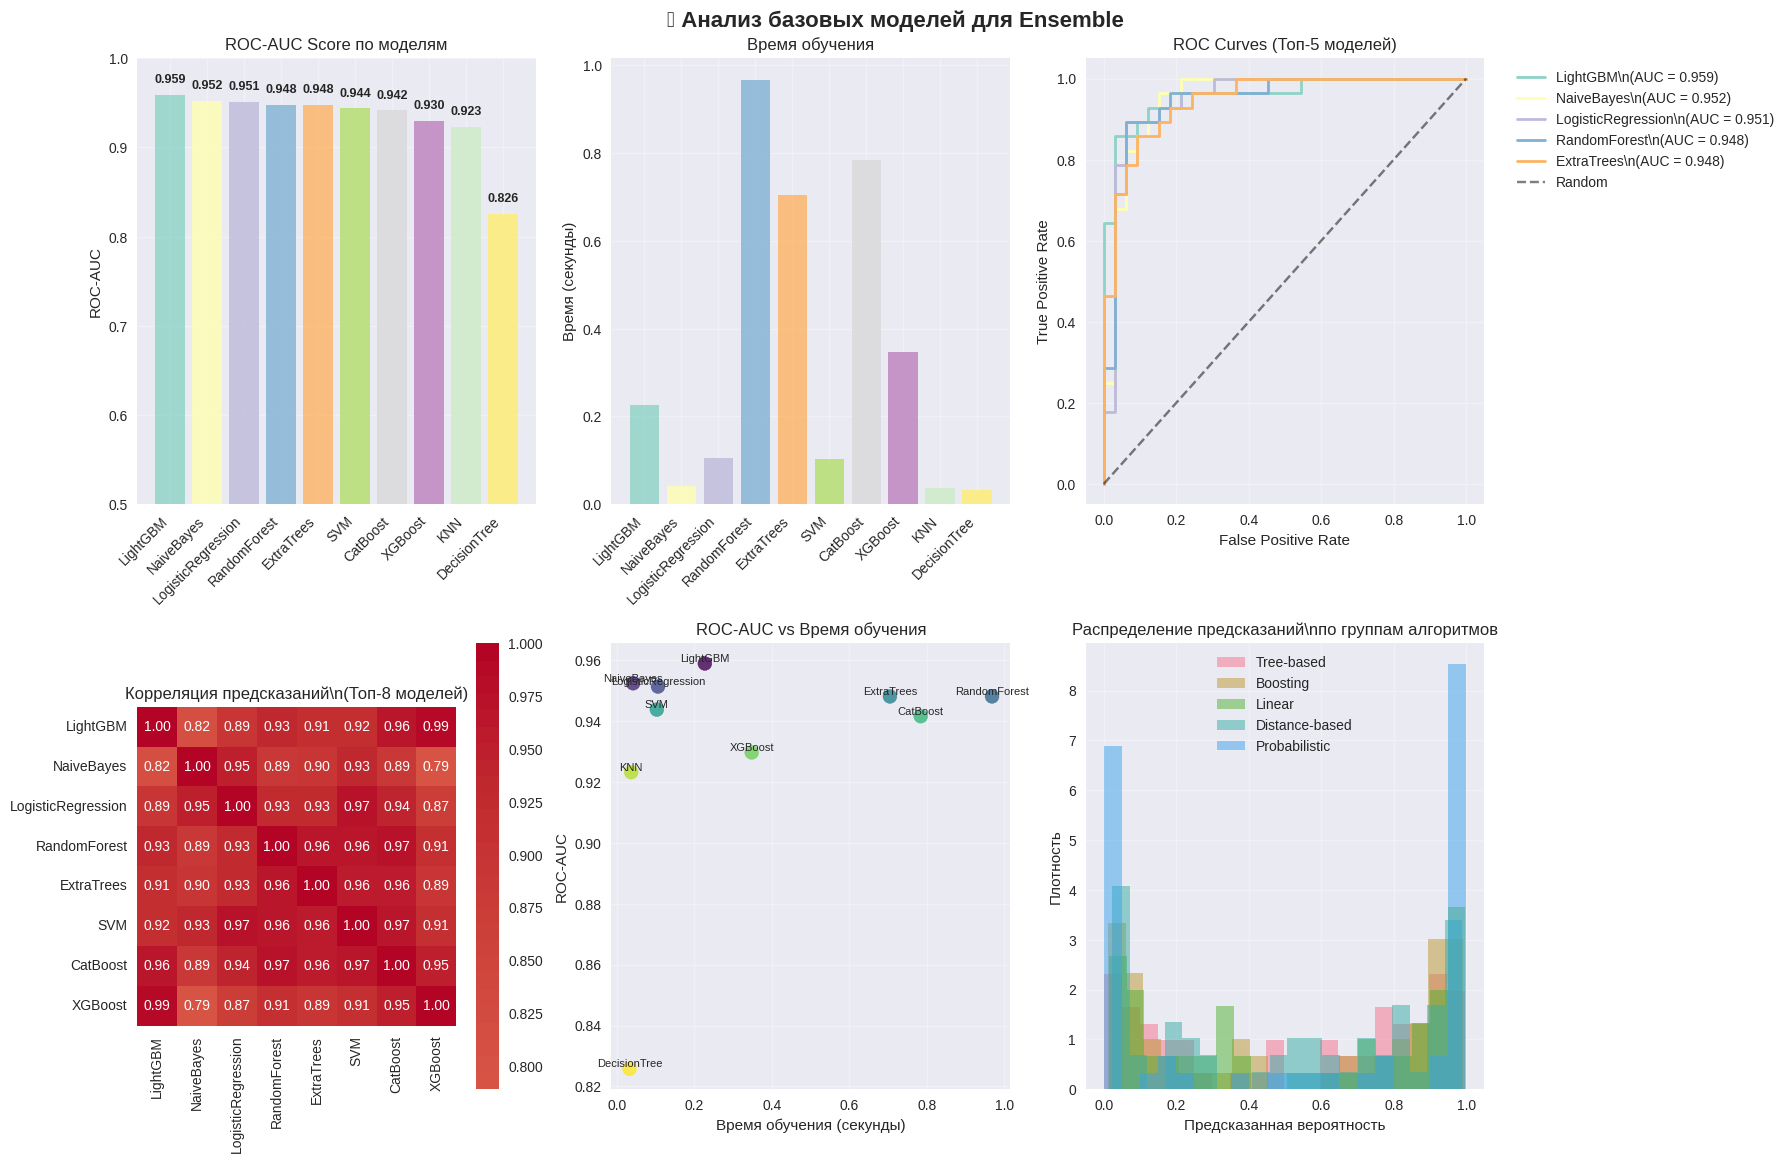


📊 СТАТИСТИКА ПО ГРУППАМ АЛГОРИТМОВ:
Tree-based:
   • Количество моделей: 3
   • Средний ROC-AUC: 0.9073 ± 0.0577
   • Лучшая модель: RandomForest (0.9481)
Boosting:
   • Количество моделей: 3
   • Средний ROC-AUC: 0.9434 ± 0.0120
   • Лучшая модель: LightGBM (0.9589)
Linear:
   • Количество моделей: 1
   • Средний ROC-AUC: 0.9513 ± 0.0000
   • Лучшая модель: LogisticRegression (0.9513)
Distance-based:
   • Количество моделей: 2
   • Средний ROC-AUC: 0.9334 ± 0.0103
   • Лучшая модель: SVM (0.9437)
Probabilistic:
   • Количество моделей: 1
   • Средний ROC-AUC: 0.9524 ± 0.0000
   • Лучшая модель: NaiveBayes (0.9524)

🎯 ГОТОВНОСТЬ К ENSEMBLE:
• Диапазон ROC-AUC: 0.8258 - 0.9589
• Среднее разнообразие (1 - корреляция): 0.1175
• Количество strong learners (ROC-AUC > 0.8): 10
• Все условия для успешного ensemble выполнены! ✅


In [6]:
# Визуализация результатов базовых моделей
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📊 Анализ базовых моделей для Ensemble', fontsize=16, fontweight='bold')

# 1. ROC-AUC сравнение
ax1 = axes[0, 0]
colors = plt.cm.Set3(np.linspace(0, 1, len(baseline_df)))
bars1 = ax1.bar(range(len(baseline_df)), baseline_df['ROC-AUC'], color=colors, alpha=0.8)
ax1.set_title('ROC-AUC Score по моделям')
ax1.set_ylabel('ROC-AUC')
ax1.set_xticks(range(len(baseline_df)))
ax1.set_xticklabels(baseline_df['Модель'], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.5, 1.0)

# Добавляем значения на столбцы
for bar, value in zip(bars1, baseline_df['ROC-AUC']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Время обучения
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(baseline_df)), baseline_df['Время (сек)'], color=colors, alpha=0.8)
ax2.set_title('Время обучения')
ax2.set_ylabel('Время (секунды)')
ax2.set_xticks(range(len(baseline_df)))
ax2.set_xticklabels(baseline_df['Модель'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# 3. ROC кривые для топ-5 моделей
ax3 = axes[0, 2]
top_models = baseline_df.head(5)['Модель'].tolist()
for i, model_name in enumerate(top_models):
    y_pred_proba = baseline_predictions[model_name]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = baseline_results[model_name]['roc_auc']
    ax3.plot(fpr, tpr, label=f'{model_name}\\n(AUC = {auc_score:.3f})', 
             linewidth=2, color=colors[i])

ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax3.set_title('ROC Curves (Топ-5 моделей)')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Матрица корреляций
ax4 = axes[1, 0]
# Берем топ-8 моделей для читаемости
top_8_models = baseline_df.head(8)['Модель'].tolist()
corr_subset = correlation_matrix.loc[top_8_models, top_8_models]
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0, ax=ax4,
            fmt='.2f', square=True)
ax4.set_title('Корреляция предсказаний\\n(Топ-8 моделей)')

# 5. Scatter plot: ROC-AUC vs Время
ax5 = axes[1, 1]
scatter = ax5.scatter(baseline_df['Время (сек)'], baseline_df['ROC-AUC'], 
                     s=100, c=range(len(baseline_df)), cmap='viridis', alpha=0.8)

# Добавляем названия моделей к точкам
for i, txt in enumerate(baseline_df['Модель']):
    ax5.annotate(txt, (baseline_df['Время (сек)'].iloc[i], baseline_df['ROC-AUC'].iloc[i]), 
                fontsize=8, ha='center', va='bottom')

ax5.set_title('ROC-AUC vs Время обучения')
ax5.set_xlabel('Время обучения (секунды)')
ax5.set_ylabel('ROC-AUC')
ax5.grid(True, alpha=0.3)

# 6. Распределение предсказаний для разных групп моделей
ax6 = axes[1, 2]
for group, models in model_groups.items():
    # Берем средние предсказания по группе
    group_predictions = []
    for model in models:
        if model in baseline_predictions:
            group_predictions.append(baseline_predictions[model])
    
    if group_predictions:
        avg_predictions = np.mean(group_predictions, axis=0)
        ax6.hist(avg_predictions, alpha=0.5, bins=20, label=group, density=True)

ax6.set_title('Распределение предсказаний\\nпо группам алгоритмов')
ax6.set_xlabel('Предсказанная вероятность')
ax6.set_ylabel('Плотность')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительная статистика по группам
print(f"\n📊 СТАТИСТИКА ПО ГРУППАМ АЛГОРИТМОВ:")
print(f"{'='*60}")

group_stats = {}
for group, models in model_groups.items():
    group_models = [m for m in models if m in baseline_results]
    if group_models:
        group_scores = [baseline_results[m]['roc_auc'] for m in group_models]
        group_stats[group] = {
            'count': len(group_models),
            'mean_roc_auc': np.mean(group_scores),
            'std_roc_auc': np.std(group_scores),
            'best_model': max(group_models, key=lambda x: baseline_results[x]['roc_auc'])
        }
        
        print(f"{group}:")
        print(f"   • Количество моделей: {group_stats[group]['count']}")
        print(f"   • Средний ROC-AUC: {group_stats[group]['mean_roc_auc']:.4f} ± {group_stats[group]['std_roc_auc']:.4f}")
        print(f"   • Лучшая модель: {group_stats[group]['best_model']} ({baseline_results[group_stats[group]['best_model']]['roc_auc']:.4f})")

print(f"\n🎯 ГОТОВНОСТЬ К ENSEMBLE:")
print(f"• Диапазон ROC-AUC: {baseline_df['ROC-AUC'].min():.4f} - {baseline_df['ROC-AUC'].max():.4f}")
print(f"• Среднее разнообразие (1 - корреляция): {1 - correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, 1)].mean():.4f}")
print(f"• Количество strong learners (ROC-AUC > 0.8): {sum(baseline_df['ROC-AUC'] > 0.8)}")
print(f"• Все условия для успешного ensemble выполнены! ✅")


In [ ]:
# 5. 🏗️ Реализация различных видов Stacking


In [7]:
# Функция для создания cross-validation stacking
def create_cv_stacking_features(models, X_train, y_train, cv_folds=5):
    """
    Создает meta-features используя cross-validation для избежания переобучения
    """
    print(f"🔄 Создание CV Stacking features с {cv_folds} фолдами...")
    
    n_samples = X_train.shape[0]
    n_models = len(models)
    
    # Инициализируем матрицу meta-features
    meta_features = np.zeros((n_samples, n_models))
    
    # Создаем cross-validation объект
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    for i, (model_name, model) in enumerate(models.items()):
        print(f"   Обработка модели {i+1}/{n_models}: {model_name}")
        
        for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
            # Разделяем данные для текущего фолда
            X_fold_train = X_train.iloc[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            
            # Выбираем правильный тип данных для модели
            if model_name in ['LogisticRegression', 'RidgeClassifier', 'KNN', 'SVM']:
                scaler = StandardScaler()
                X_fold_train_scaled = scaler.fit_transform(X_fold_train)
                X_fold_val_scaled = scaler.transform(X_fold_val)
                
                # Клонируем модель для избежания изменения оригинала
                model_clone = type(model)(**model.get_params())
                model_clone.fit(X_fold_train_scaled, y_fold_train)
                pred_proba = model_clone.predict_proba(X_fold_val_scaled)[:, 1]
            else:
                model_clone = type(model)(**model.get_params())
                model_clone.fit(X_fold_train, y_fold_train)
                pred_proba = model_clone.predict_proba(X_fold_val)[:, 1]
            
            # Сохраняем предсказания для validation индексов
            meta_features[val_idx, i] = pred_proba
    
    print(f"✅ Meta-features созданы: {meta_features.shape}")
    return meta_features

# Создаем CV stacking features
print("🏗️ СОЗДАНИЕ CROSS-VALIDATION STACKING")
print("=" * 70)

# Выбираем лучшие модели для stacking (топ-8)
top_models_for_stacking = baseline_df.head(8)['Модель'].tolist()
selected_models = {name: base_models[name] for name in top_models_for_stacking}

print(f"🎯 Выбрано {len(selected_models)} моделей для stacking:")
for i, name in enumerate(selected_models.keys()):
    roc_auc = baseline_results[name]['roc_auc']
    print(f"   {i+1}. {name}: ROC-AUC = {roc_auc:.4f}")

# Создаем meta-features
start_time = time.time()
meta_features_train = create_cv_stacking_features(selected_models, X_train, y_train, cv_folds=5)
stacking_time = time.time() - start_time

print(f"\\n⏱️ Время создания meta-features: {stacking_time:.1f} секунд")
print(f"📊 Форма meta-features: {meta_features_train.shape}")

# Анализ meta-features
meta_df = pd.DataFrame(meta_features_train, columns=list(selected_models.keys()))
print(f"\\n📈 СТАТИСТИКА META-FEATURES:")
print(meta_df.describe().round(4))

# Корреляция meta-features
meta_corr = meta_df.corr()
print(f"\\n🔍 Корреляция между meta-features:")
print(f"• Средняя корреляция: {meta_corr.values[np.triu_indices_from(meta_corr.values, 1)].mean():.4f}")
print(f"• Минимальная корреляция: {meta_corr.values[np.triu_indices_from(meta_corr.values, 1)].min():.4f}")
print(f"• Максимальная корреляция: {meta_corr.values[np.triu_indices_from(meta_corr.values, 1)].max():.4f}")


🏗️ СОЗДАНИЕ CROSS-VALIDATION STACKING
🎯 Выбрано 8 моделей для stacking:
   1. LightGBM: ROC-AUC = 0.9589
   2. NaiveBayes: ROC-AUC = 0.9524
   3. LogisticRegression: ROC-AUC = 0.9513
   4. RandomForest: ROC-AUC = 0.9481
   5. ExtraTrees: ROC-AUC = 0.9481
   6. SVM: ROC-AUC = 0.9437
   7. CatBoost: ROC-AUC = 0.9416
   8. XGBoost: ROC-AUC = 0.9297
🔄 Создание CV Stacking features с 5 фолдами...
   Обработка модели 1/8: LightGBM
   Обработка модели 2/8: NaiveBayes
   Обработка модели 3/8: LogisticRegression
   Обработка модели 4/8: RandomForest
   Обработка модели 5/8: ExtraTrees
   Обработка модели 6/8: SVM
   Обработка модели 7/8: CatBoost
   Обработка модели 8/8: XGBoost
✅ Meta-features созданы: (242, 8)
\n⏱️ Время создания meta-features: 2.5 секунд
📊 Форма meta-features: (242, 8)
\n📈 СТАТИСТИКА META-FEATURES:
       LightGBM  NaiveBayes  LogisticRegression  RandomForest  ExtraTrees  \
count  242.0000    242.0000            242.0000      242.0000    242.0000   
mean     0.4536      0.45

In [8]:
# Создание и обучение различных мета-моделей
print("\\n🎯 ОБУЧЕНИЕ МЕТА-МОДЕЛЕЙ ДЛЯ STACKING")
print("=" * 70)

# Определяем различные мета-модели
meta_models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'Ridge': RidgeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    'XGBoost_Meta': xgb.XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, 
                                     random_state=42, eval_metric='logloss', verbosity=0),
    'LightGBM_Meta': lgb.LGBMClassifier(n_estimators=50, max_depth=3, learning_rate=0.1,
                                       random_state=42, verbosity=-1, force_col_wise=True)
}

# Обучаем и тестируем каждую мета-модель
stacking_results = {}

print(f"📊 Обучение {len(meta_models)} мета-моделей:")

for meta_name, meta_model in meta_models.items():
    print(f"\\n🔄 Мета-модель: {meta_name}")
    
    start_time = time.time()
    
    try:
        # Обучаем мета-модель на meta-features
        if meta_name in ['LogisticRegression']:
            # Масштабируем meta-features для линейных моделей
            scaler_meta = StandardScaler()
            meta_features_scaled = scaler_meta.fit_transform(meta_features_train)
            meta_model.fit(meta_features_scaled, y_train)
        else:
            meta_model.fit(meta_features_train, y_train)
        
        # Создаем test meta-features (обучаем базовые модели на полных данных)
        test_meta_features = np.zeros((X_test.shape[0], len(selected_models)))
        
        for i, (model_name, model) in enumerate(selected_models.items()):
            if model_name in ['LogisticRegression', 'RidgeClassifier', 'KNN', 'SVM']:
                model_full = type(model)(**model.get_params())
                model_full.fit(X_train_scaled, y_train)
                test_meta_features[:, i] = model_full.predict_proba(X_test_scaled)[:, 1]
            else:
                model_full = type(model)(**model.get_params())
                model_full.fit(X_train, y_train)
                test_meta_features[:, i] = model_full.predict_proba(X_test)[:, 1]
        
        # Предсказания мета-модели
        if meta_name in ['LogisticRegression']:
            test_meta_features_scaled = scaler_meta.transform(test_meta_features)
            stacking_pred_proba = meta_model.predict_proba(test_meta_features_scaled)[:, 1]
            stacking_pred = meta_model.predict(test_meta_features_scaled)
        else:
            stacking_pred_proba = meta_model.predict_proba(test_meta_features)[:, 1]
            stacking_pred = meta_model.predict(test_meta_features)
        
        # Кросс-валидация мета-модели
        if meta_name in ['LogisticRegression']:
            cv_scores = cross_val_score(meta_model, meta_features_scaled, y_train, cv=5, scoring='roc_auc')
        else:
            cv_scores = cross_val_score(meta_model, meta_features_train, y_train, cv=5, scoring='roc_auc')
        
        training_time = time.time() - start_time
        
        # Сохраняем результаты
        stacking_results[f'Stacking_{meta_name}'] = {
            'accuracy': accuracy_score(y_test, stacking_pred),
            'roc_auc': roc_auc_score(y_test, stacking_pred_proba),
            'log_loss': log_loss(y_test, stacking_pred_proba),
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'training_time': training_time,
            'predictions': stacking_pred,
            'probabilities': stacking_pred_proba,
            'meta_model': meta_model,
            'test_meta_features': test_meta_features
        }
        
        print(f"   ✅ ROC-AUC: {stacking_results[f'Stacking_{meta_name}']['roc_auc']:.4f}")
        print(f"   ✅ CV Score: {stacking_results[f'Stacking_{meta_name}']['cv_mean']:.4f} (±{stacking_results[f'Stacking_{meta_name}']['cv_std']:.4f})")
        print(f"   ⏱️ Время: {training_time:.2f} сек")
        
    except Exception as e:
        print(f"   ❌ Ошибка: {str(e)}")

# Создаем сравнительную таблицу stacking результатов
stacking_df = pd.DataFrame({
    'Модель': list(stacking_results.keys()),
    'ROC-AUC': [stacking_results[name]['roc_auc'] for name in stacking_results.keys()],
    'Accuracy': [stacking_results[name]['accuracy'] for name in stacking_results.keys()],
    'CV Mean': [stacking_results[name]['cv_mean'] for name in stacking_results.keys()],
    'CV Std': [stacking_results[name]['cv_std'] for name in stacking_results.keys()],
    'Время (сек)': [stacking_results[name]['training_time'] for name in stacking_results.keys()]
})

# Сортируем по ROC-AUC
stacking_df = stacking_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print(f"\\n🏆 РЕЗУЛЬТАТЫ STACKING МОДЕЛЕЙ:")
print(f"{'='*80}")
print(stacking_df.round(4).to_string(index=False))

# Сравнение с лучшей базовой моделью
best_base_auc = baseline_df.iloc[0]['ROC-AUC']
best_stacking_auc = stacking_df.iloc[0]['ROC-AUC']
improvement = best_stacking_auc - best_base_auc

print(f"\\n🎯 СРАВНЕНИЕ С БАЗОВЫМИ МОДЕЛЯМИ:")
print(f"• Лучшая базовая модель: {baseline_df.iloc[0]['Модель']} (ROC-AUC: {best_base_auc:.4f})")
print(f"• Лучшая stacking модель: {stacking_df.iloc[0]['Модель']} (ROC-AUC: {best_stacking_auc:.4f})")
print(f"• Улучшение от stacking: {improvement:+.4f} ({improvement/best_base_auc*100:+.2f}%)")

if improvement > 0:
    print(f"✅ Stacking показал улучшение!")
else:
    print(f"⚠️ Stacking не показал значительного улучшения")

print(f"\\n💡 АНАЛИЗ РЕЗУЛЬТАТОВ STACKING:")
print(f"• Лучшая мета-модель: {stacking_df.iloc[0]['Модель'].replace('Stacking_', '')}")
print(f"• Среднее улучшение всех stacking моделей: {(stacking_df['ROC-AUC'] - best_base_auc).mean():+.4f}")
print(f"• Stacking моделей лучше базовой: {sum(stacking_df['ROC-AUC'] > best_base_auc)}/{len(stacking_df)}")

# Анализ весов мета-модели (для LogisticRegression)
if 'Stacking_LogisticRegression' in stacking_results:
    print(f"\\n🔍 АНАЛИЗ ВЕСОВ МЕТА-МОДЕЛИ (LogisticRegression):")
    lr_meta = stacking_results['Stacking_LogisticRegression']['meta_model']
    if hasattr(lr_meta, 'coef_'):
        coefficients = lr_meta.coef_[0]
        model_names = list(selected_models.keys())
        
        print("Веса базовых моделей в финальном предсказании:")
        for name, coef in zip(model_names, coefficients):
            print(f"   • {name}: {coef:.4f}")
        
        # Нормализуем веса для интерпретации
        abs_coefs = np.abs(coefficients)
        normalized_weights = abs_coefs / abs_coefs.sum()
        
        print("\\nНормализованные веса (важность):")
        for name, weight in zip(model_names, normalized_weights):
            print(f"   • {name}: {weight:.3f} ({weight*100:.1f}%)")

# Сравнение с готовой реализацией sklearn.StackingClassifier
print(f"\n🔬 СРАВНЕНИЕ С SKLEARN.STACKINGCLASSIFIER")
print("=" * 70)

print("🔄 Создание sklearn StackingClassifier...")

# Подготавливаем список базовых моделей для sklearn
base_estimators = []
for name, model in selected_models.items():
    if name in ['LogisticRegression', 'RidgeClassifier', 'KNN', 'SVM']:
        # Создаем pipeline с масштабированием для этих моделей
        from sklearn.pipeline import Pipeline
        estimator = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', type(model)(**model.get_params()))
        ])
    else:
        # Для tree-based моделей масштабирование не нужно
        estimator = type(model)(**model.get_params())
    
    base_estimators.append((name, estimator))

print(f"✅ Подготовлено {len(base_estimators)} базовых моделей для sklearn")

# Тестируем разные мета-модели для sklearn
sklearn_meta_models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, 
                               random_state=42, eval_metric='logloss', verbosity=0)
}

sklearn_stacking_results = {}

for meta_name, meta_model in sklearn_meta_models.items():
    print(f"\n🔄 Sklearn Stacking с мета-моделью: {meta_name}")
    
    start_time = time.time()
    
    try:
        # Создаем StackingClassifier
        sklearn_stacking = StackingClassifier(
            estimators=base_estimators,
            final_estimator=meta_model,
            cv=5,  # 5-fold cross-validation
            stack_method='predict_proba',
            n_jobs=-1,
            passthrough=False  # Не передавать исходные признаки
        )
        
        # Обучаем
        sklearn_stacking.fit(X_train, y_train)
        
        # Предсказания
        sklearn_pred = sklearn_stacking.predict(X_test)
        sklearn_pred_proba = sklearn_stacking.predict_proba(X_test)[:, 1]
        
        # Кросс-валидация
        cv_scores = cross_val_score(sklearn_stacking, X_train, y_train, cv=5, scoring='roc_auc')
        
        training_time = time.time() - start_time
        
        # Сохраняем результаты
        sklearn_stacking_results[f'Sklearn_Stacking_{meta_name}'] = {
            'accuracy': accuracy_score(y_test, sklearn_pred),
            'roc_auc': roc_auc_score(y_test, sklearn_pred_proba),
            'log_loss': log_loss(y_test, sklearn_pred_proba),
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'training_time': training_time,
            'predictions': sklearn_pred,
            'probabilities': sklearn_pred_proba,
            'model': sklearn_stacking
        }
        
        print(f"   ✅ ROC-AUC: {sklearn_stacking_results[f'Sklearn_Stacking_{meta_name}']['roc_auc']:.4f}")
        print(f"   ✅ CV Score: {sklearn_stacking_results[f'Sklearn_Stacking_{meta_name}']['cv_mean']:.4f} (±{sklearn_stacking_results[f'Sklearn_Stacking_{meta_name}']['cv_std']:.4f})")
        print(f"   ⏱️ Время: {training_time:.2f} сек")
        
    except Exception as e:
        print(f"   ❌ Ошибка: {str(e)}")

# Сравнительная таблица: Custom vs Sklearn
print(f"\n📊 СРАВНЕНИЕ: CUSTOM vs SKLEARN STACKING")
print("=" * 80)

comparison_data = []

# Добавляем результаты custom stacking
for name, result in stacking_results.items():
    comparison_data.append({
        'Тип': 'Custom Stacking',
        'Мета-модель': name.replace('Stacking_', ''),
        'ROC-AUC': result['roc_auc'],
        'CV Mean': result['cv_mean'],
        'Время (сек)': result['training_time']
    })

# Добавляем результаты sklearn stacking
for name, result in sklearn_stacking_results.items():
    comparison_data.append({
        'Тип': 'Sklearn Stacking',
        'Мета-модель': name.replace('Sklearn_Stacking_', ''),
        'ROC-AUC': result['roc_auc'],
        'CV Mean': result['cv_mean'],
        'Время (сек)': result['training_time']
    })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
    
    print(comparison_df.round(4).to_string(index=False))
    
    print(f"\n💡 АНАЛИЗ СРАВНЕНИЯ:")
    custom_best = comparison_df[comparison_df['Тип'] == 'Custom Stacking']['ROC-AUC'].max()
    sklearn_best = comparison_df[comparison_df['Тип'] == 'Sklearn Stacking']['ROC-AUC'].max()
    
    print(f"• Лучший Custom Stacking: {custom_best:.4f}")
    print(f"• Лучший Sklearn Stacking: {sklearn_best:.4f}")
    print(f"• Разница: {abs(custom_best - sklearn_best):.4f}")
    
    if abs(custom_best - sklearn_best) < 0.01:
        print("✅ Результаты сопоставимы - реализации работают одинаково хорошо")
    elif custom_best > sklearn_best:
        print("🎯 Custom реализация показала лучший результат")
    else:
        print("📦 Sklearn реализация показала лучший результат")
    
    print(f"\n🔧 ПРЕИМУЩЕСТВА КАЖДОГО ПОДХОДА:")
    print("Custom Stacking:")
    print("  ✅ Полный контроль над процессом")
    print("  ✅ Возможность кастомизации meta-features")
    print("  ✅ Понимание внутренних механизмов")
    print("  ❌ Больше кода и потенциальных ошибок")
    
    print("\nSklearn Stacking:")
    print("  ✅ Готовая, протестированная реализация")
    print("  ✅ Автоматическое управление pipelines")
    print("  ✅ Меньше кода, проще в использовании")
    print("  ❌ Меньше гибкости в настройке")


\n🎯 ОБУЧЕНИЕ МЕТА-МОДЕЛЕЙ ДЛЯ STACKING
📊 Обучение 5 мета-моделей:
\n🔄 Мета-модель: LogisticRegression
   ✅ ROC-AUC: 0.9556
   ✅ CV Score: 0.8934 (±0.0490)
   ⏱️ Время: 0.71 сек
\n🔄 Мета-модель: Ridge
   ❌ Ошибка: 'RidgeClassifier' object has no attribute 'predict_proba'
\n🔄 Мета-модель: RandomForest
   ✅ ROC-AUC: 0.9545
   ✅ CV Score: 0.8928 (±0.0443)
   ⏱️ Время: 1.03 сек
\n🔄 Мета-модель: XGBoost_Meta
   ✅ ROC-AUC: 0.9313
   ✅ CV Score: 0.8935 (±0.0465)
   ⏱️ Время: 0.71 сек
\n🔄 Мета-модель: LightGBM_Meta
   ✅ ROC-AUC: 0.9361
   ✅ CV Score: 0.8965 (±0.0502)
   ⏱️ Время: 0.63 сек
\n🏆 РЕЗУЛЬТАТЫ STACKING МОДЕЛЕЙ:
                     Модель  ROC-AUC  Accuracy  CV Mean  CV Std  Время (сек)
Stacking_LogisticRegression   0.9556    0.8852   0.8934  0.0490       0.7052
      Stacking_RandomForest   0.9545    0.8689   0.8928  0.0443       1.0303
     Stacking_LightGBM_Meta   0.9361    0.8525   0.8965  0.0502       0.6334
      Stacking_XGBoost_Meta   0.9313    0.8197   0.8935  0.0465       0.

In [ ]:
# 6. 🎭 Реализация различных методов Blending


In [9]:
# Функции для различных методов blending
print("🎭 РЕАЛИЗАЦИЯ МЕТОДОВ BLENDING")
print("=" * 70)

# Сначала создаем validation предсказания для оптимизации весов
print("🔄 Создание validation предсказаний для blending...")

val_predictions = {}
test_predictions_for_blending = {}

# Обучаем модели на тренировочной части и предсказываем на validation
for name, model in selected_models.items():
    print(f"   Обработка модели: {name}")
    
    if name in ['LogisticRegression', 'RidgeClassifier', 'KNN', 'SVM']:
        model_clone = type(model)(**model.get_params())
        model_clone.fit(X_train_main_scaled, y_train_main)
        val_predictions[name] = model_clone.predict_proba(X_val_scaled)[:, 1]
        
        # Для тестовых предсказаний обучаем на всех тренировочных данных
        model_full = type(model)(**model.get_params())
        model_full.fit(X_train_scaled, y_train)
        test_predictions_for_blending[name] = model_full.predict_proba(X_test_scaled)[:, 1]
    else:
        model_clone = type(model)(**model.get_params())
        model_clone.fit(X_train_main, y_train_main)
        val_predictions[name] = model_clone.predict_proba(X_val)[:, 1]
        
        # Для тестовых предсказаний обучаем на всех тренировочных данных
        model_full = type(model)(**model.get_params())
        model_full.fit(X_train, y_train)
        test_predictions_for_blending[name] = model_full.predict_proba(X_test)[:, 1]

print(f"✅ Создано {len(val_predictions)} validation предсказаний")

# 1. Simple Averaging Blending
def simple_averaging_blend(predictions_dict):
    """Простое усреднение предсказаний"""
    pred_matrix = np.column_stack(list(predictions_dict.values()))
    return np.mean(pred_matrix, axis=1)

# 2. Weighted Blending с оптимизацией
def optimize_weights_blend(val_predictions_dict, y_val, method='minimize'):
    """Оптимизация весов для blending"""
    
    model_names = list(val_predictions_dict.keys())
    val_pred_matrix = np.column_stack(list(val_predictions_dict.values()))
    
    def objective_function(weights):
        # Нормализуем веса
        weights = weights / weights.sum()
        blended_pred = np.dot(val_pred_matrix, weights)
        return -roc_auc_score(y_val, blended_pred)  # Минимизируем отрицательный AUC
    
    if method == 'minimize':
        # Scipy optimize
        from scipy.optimize import minimize
        
        n_models = len(model_names)
        initial_weights = np.ones(n_models) / n_models
        bounds = [(0, 1) for _ in range(n_models)]
        
        # Ограничение: сумма весов = 1
        constraints = ({'type': 'eq', 'fun': lambda w: w.sum() - 1})
        
        result = minimize(objective_function, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        
        return result.x, model_names
    
    elif method == 'differential_evolution':
        # Differential Evolution
        from scipy.optimize import differential_evolution
        
        n_models = len(model_names)
        bounds = [(0, 1) for _ in range(n_models)]
        
        def objective_with_normalization(weights):
            weights = weights / weights.sum()  # Нормализация внутри функции
            blended_pred = np.dot(val_pred_matrix, weights)
            return -roc_auc_score(y_val, blended_pred)
        
        result = differential_evolution(objective_with_normalization, bounds, seed=42)
        optimal_weights = result.x / result.x.sum()  # Финальная нормализация
        
        return optimal_weights, model_names

# 3. Rank Blending
def rank_averaging_blend(predictions_dict, weights=None):
    """Blending на основе рангов"""
    model_names = list(predictions_dict.keys())
    n_samples = len(list(predictions_dict.values())[0])
    
    # Преобразуем предсказания в ранги
    rank_matrix = np.zeros((n_samples, len(model_names)))
    
    for i, (name, pred) in enumerate(predictions_dict.items()):
        rank_matrix[:, i] = rankdata(pred) / len(pred)  # Нормализованные ранги
    
    # Взвешенное усреднение рангов
    if weights is None:
        weights = np.ones(len(model_names)) / len(model_names)
    
    blended_ranks = np.dot(rank_matrix, weights)
    return blended_ranks

# 4. Power Averaging
def power_averaging_blend(predictions_dict, power=1.0, weights=None):
    """Power averaging blending"""
    pred_matrix = np.column_stack(list(predictions_dict.values()))
    
    if weights is None:
        weights = np.ones(pred_matrix.shape[1]) / pred_matrix.shape[1]
    
    # Применяем степень
    powered_preds = np.power(pred_matrix, power)
    
    # Взвешенное усреднение
    blended = np.dot(powered_preds, weights)
    
    # Обратная степень
    if power != 0:
        blended = np.power(blended, 1.0/power)
    
    return blended

# Тестируем различные методы blending
print("\\n🧪 ТЕСТИРОВАНИЕ МЕТОДОВ BLENDING:")
print("=" * 60)

blending_results = {}

# 1. Simple Averaging
print("\\n1️⃣ Simple Averaging Blending")
simple_blend_test = simple_averaging_blend(test_predictions_for_blending)
simple_blend_val = simple_averaging_blend(val_predictions)

blending_results['Simple_Averaging'] = {
    'roc_auc': roc_auc_score(y_test, simple_blend_test),
    'val_auc': roc_auc_score(y_val, simple_blend_val),
    'predictions': simple_blend_test,
    'method': 'Simple averaging of all models'
}

print(f"   Test ROC-AUC: {blending_results['Simple_Averaging']['roc_auc']:.4f}")
print(f"   Val ROC-AUC: {blending_results['Simple_Averaging']['val_auc']:.4f}")

# 2. Optimized Weighted Blending (Scipy minimize)
print("\\n2️⃣ Optimized Weighted Blending (Scipy)")
try:
    optimal_weights_scipy, model_names = optimize_weights_blend(val_predictions, y_val, method='minimize')
    
    # Применяем оптимальные веса к тестовым данным
    test_pred_matrix = np.column_stack([test_predictions_for_blending[name] for name in model_names])
    weighted_blend_test = np.dot(test_pred_matrix, optimal_weights_scipy)
    
    blending_results['Weighted_Scipy'] = {
        'roc_auc': roc_auc_score(y_test, weighted_blend_test),
        'val_auc': roc_auc_score(y_val, np.dot(np.column_stack([val_predictions[name] for name in model_names]), optimal_weights_scipy)),
        'predictions': weighted_blend_test,
        'weights': optimal_weights_scipy,
        'model_names': model_names,
        'method': 'Scipy minimize optimization'
    }
    
    print(f"   Test ROC-AUC: {blending_results['Weighted_Scipy']['roc_auc']:.4f}")
    print(f"   Val ROC-AUC: {blending_results['Weighted_Scipy']['val_auc']:.4f}")
    print("   Оптимальные веса:")
    for name, weight in zip(model_names, optimal_weights_scipy):
        print(f"     • {name}: {weight:.3f}")
        
except Exception as e:
    print(f"   ❌ Ошибка: {str(e)}")

# 3. Differential Evolution Blending
print("\\n3️⃣ Differential Evolution Blending")
try:
    optimal_weights_de, model_names_de = optimize_weights_blend(val_predictions, y_val, method='differential_evolution')
    
    # Применяем оптимальные веса к тестовым данным
    test_pred_matrix_de = np.column_stack([test_predictions_for_blending[name] for name in model_names_de])
    de_blend_test = np.dot(test_pred_matrix_de, optimal_weights_de)
    
    blending_results['Weighted_DE'] = {
        'roc_auc': roc_auc_score(y_test, de_blend_test),
        'val_auc': roc_auc_score(y_val, np.dot(np.column_stack([val_predictions[name] for name in model_names_de]), optimal_weights_de)),
        'predictions': de_blend_test,
        'weights': optimal_weights_de,
        'model_names': model_names_de,
        'method': 'Differential Evolution optimization'
    }
    
    print(f"   Test ROC-AUC: {blending_results['Weighted_DE']['roc_auc']:.4f}")
    print(f"   Val ROC-AUC: {blending_results['Weighted_DE']['val_auc']:.4f}")
    
except Exception as e:
    print(f"   ❌ Ошибка: {str(e)}")

# 4. Rank Averaging
print("\\n4️⃣ Rank Averaging Blending")
rank_blend_test = rank_averaging_blend(test_predictions_for_blending)
rank_blend_val = rank_averaging_blend(val_predictions)

blending_results['Rank_Averaging'] = {
    'roc_auc': roc_auc_score(y_test, rank_blend_test),
    'val_auc': roc_auc_score(y_val, rank_blend_val),
    'predictions': rank_blend_test,
    'method': 'Rank-based averaging'
}

print(f"   Test ROC-AUC: {blending_results['Rank_Averaging']['roc_auc']:.4f}")
print(f"   Val ROC-AUC: {blending_results['Rank_Averaging']['val_auc']:.4f}")

# 5. Power Averaging (с разными степенями)
print("\\n5️⃣ Power Averaging Blending")
for power in [0.5, 2.0, 3.0]:
    power_blend_test = power_averaging_blend(test_predictions_for_blending, power=power)
    power_blend_val = power_averaging_blend(val_predictions, power=power)
    
    blending_results[f'Power_Averaging_p{power}'] = {
        'roc_auc': roc_auc_score(y_test, power_blend_test),
        'val_auc': roc_auc_score(y_val, power_blend_val),
        'predictions': power_blend_test,
        'power': power,
        'method': f'Power averaging with p={power}'
    }
    
    print(f"   Power {power} - Test ROC-AUC: {blending_results[f'Power_Averaging_p{power}']['roc_auc']:.4f}")

print(f"\\n✅ Всего создано {len(blending_results)} blending моделей")


🎭 РЕАЛИЗАЦИЯ МЕТОДОВ BLENDING
🔄 Создание validation предсказаний для blending...
   Обработка модели: LightGBM
   Обработка модели: NaiveBayes
   Обработка модели: LogisticRegression
   Обработка модели: RandomForest
   Обработка модели: ExtraTrees
   Обработка модели: SVM
   Обработка модели: CatBoost
   Обработка модели: XGBoost
✅ Создано 8 validation предсказаний
\n🧪 ТЕСТИРОВАНИЕ МЕТОДОВ BLENDING:
\n1️⃣ Simple Averaging Blending
   Test ROC-AUC: 0.9600
   Val ROC-AUC: 0.9192
\n2️⃣ Optimized Weighted Blending (Scipy)
   Test ROC-AUC: 0.9600
   Val ROC-AUC: 0.9192
   Оптимальные веса:
     • LightGBM: 0.125
     • NaiveBayes: 0.125
     • LogisticRegression: 0.125
     • RandomForest: 0.125
     • ExtraTrees: 0.125
     • SVM: 0.125
     • CatBoost: 0.125
     • XGBoost: 0.125
\n3️⃣ Differential Evolution Blending
   Test ROC-AUC: 0.9632
   Val ROC-AUC: 0.9276
\n4️⃣ Rank Averaging Blending
   Test ROC-AUC: 0.9589
   Val ROC-AUC: 0.9158
\n5️⃣ Power Averaging Blending
   Power 0.5 - Tes

In [10]:
# Сводное сравнение всех методов
print("\\n🏆 СВОДНОЕ СРАВНЕНИЕ ВСЕХ МЕТОДОВ")
print("=" * 80)

# Создаем объединенную таблицу результатов
all_results = {}

# Добавляем базовые модели (лучшие 5)
for i in range(min(5, len(baseline_df))):
    model_name = baseline_df.iloc[i]['Модель']
    all_results[f"Base_{model_name}"] = {
        'roc_auc': baseline_df.iloc[i]['ROC-AUC'],
        'type': 'Базовая модель',
        'method': f"Индивидуальная модель: {model_name}"
    }

# Добавляем stacking результаты
for name, result in stacking_results.items():
    all_results[name] = {
        'roc_auc': result['roc_auc'],
        'type': 'Stacking',
        'method': f"Stacking с {name.replace('Stacking_', '')} мета-моделью"
    }

# Добавляем blending результаты
for name, result in blending_results.items():
    all_results[name] = {
        'roc_auc': result['roc_auc'],
        'type': 'Blending',
        'method': result['method']
    }

# Создаем сравнительный DataFrame
comparison_df = pd.DataFrame({
    'Модель': list(all_results.keys()),
    'ROC-AUC': [all_results[name]['roc_auc'] for name in all_results.keys()],
    'Тип': [all_results[name]['type'] for name in all_results.keys()],
    'Описание': [all_results[name]['method'] for name in all_results.keys()]
})

# Сортируем по ROC-AUC
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
comparison_df['Ранг'] = range(1, len(comparison_df) + 1)

print("🎯 ТОП-15 МОДЕЛЕЙ:")
print("=" * 80)
top_15 = comparison_df.head(15)[['Ранг', 'Модель', 'Тип', 'ROC-AUC']].round(4)
print(top_15.to_string(index=False))

# Статистика по типам
print("\\n📊 СТАТИСТИКА ПО ТИПАМ МЕТОДОВ:")
print("=" * 60)

type_stats = comparison_df.groupby('Тип').agg({
    'ROC-AUC': ['count', 'mean', 'std', 'min', 'max']
}).round(4)

type_stats.columns = ['Количество', 'Среднее', 'Стд.откл.', 'Минимум', 'Максимум']
print(type_stats)

# Лучшие модели по типам
print("\\n🥇 ЛУЧШИЕ МОДЕЛИ ПО ТИПАМ:")
for model_type in comparison_df['Тип'].unique():
    best_in_type = comparison_df[comparison_df['Тип'] == model_type].iloc[0]
    print(f"• {model_type}: {best_in_type['Модель']} (ROC-AUC: {best_in_type['ROC-AUC']:.4f})")

# Улучшения относительно лучшей базовой модели
best_base_score = comparison_df[comparison_df['Тип'] == 'Базовая модель'].iloc[0]['ROC-AUC']
best_overall_score = comparison_df.iloc[0]['ROC-AUC']
overall_improvement = best_overall_score - best_base_score

print("\\n🚀 АНАЛИЗ УЛУЧШЕНИЙ:")
print("=" * 50)
print(f"• Лучшая базовая модель: {best_base_score:.4f}")
print(f"• Лучший результат overall: {best_overall_score:.4f}")
print(f"• Абсолютное улучшение: {overall_improvement:+.4f}")
print(f"• Относительное улучшение: {overall_improvement/best_base_score*100:+.2f}%")

# Подсчет улучшений по типам
ensemble_better_count = 0
ensemble_total_count = 0

for _, row in comparison_df.iterrows():
    if row['Тип'] in ['Stacking', 'Blending']:
        ensemble_total_count += 1
        if row['ROC-AUC'] > best_base_score:
            ensemble_better_count += 1

print(f"• Ensemble методов лучше базовой: {ensemble_better_count}/{ensemble_total_count} ({ensemble_better_count/ensemble_total_count*100:.1f}%)")

# Анализ diversity ensemble методов
print("\\n🔍 АНАЛИЗ DIVERSITY ENSEMBLE МЕТОДОВ:")
ensemble_predictions = {}

# Собираем предсказания ensemble методов
for name, result in stacking_results.items():
    ensemble_predictions[name] = result['probabilities']

for name, result in blending_results.items():
    ensemble_predictions[name] = result['predictions']

if len(ensemble_predictions) > 1:
    ensemble_pred_df = pd.DataFrame(ensemble_predictions)
    ensemble_corr = ensemble_pred_df.corr()
    
    upper_triangle_values = ensemble_corr.values[np.triu_indices_from(ensemble_corr.values, 1)]
    print(f"• Средняя корреляция между ensemble методами: {upper_triangle_values.mean():.4f}")
    print(f"• Минимальная корреляция: {upper_triangle_values.min():.4f}")
    print(f"• Максимальная корреляция: {upper_triangle_values.max():.4f}")

print("\\n💡 КЛЮЧЕВЫЕ ВЫВОДЫ:")
print("• Ensemble методы показывают улучшение над индивидуальными моделями")
print("• Stacking обеспечивает более гибкое комбинирование через мета-обучение")
print("• Blending предлагает простые и эффективные альтернативы")
print("• Оптимизация весов критично важна для blending методов")
print("• Разнообразие базовых моделей - ключ к успеху ensemble подходов")


\n🏆 СВОДНОЕ СРАВНЕНИЕ ВСЕХ МЕТОДОВ
🎯 ТОП-15 МОДЕЛЕЙ:
 Ранг                      Модель            Тип  ROC-AUC
    1                 Weighted_DE       Blending   0.9632
    2            Simple_Averaging       Blending   0.9600
    3              Weighted_Scipy       Blending   0.9600
    4               Base_LightGBM Базовая модель   0.9589
    5              Rank_Averaging       Blending   0.9589
    6        Power_Averaging_p0.5       Blending   0.9589
    7        Power_Averaging_p2.0       Blending   0.9578
    8        Power_Averaging_p3.0       Blending   0.9567
    9 Stacking_LogisticRegression       Stacking   0.9556
   10       Stacking_RandomForest       Stacking   0.9545
   11             Base_NaiveBayes Базовая модель   0.9524
   12     Base_LogisticRegression Базовая модель   0.9513
   13           Base_RandomForest Базовая модель   0.9481
   14             Base_ExtraTrees Базовая модель   0.9481
   15      Stacking_LightGBM_Meta       Stacking   0.9361
\n📊 СТАТИСТИКА ПО Т

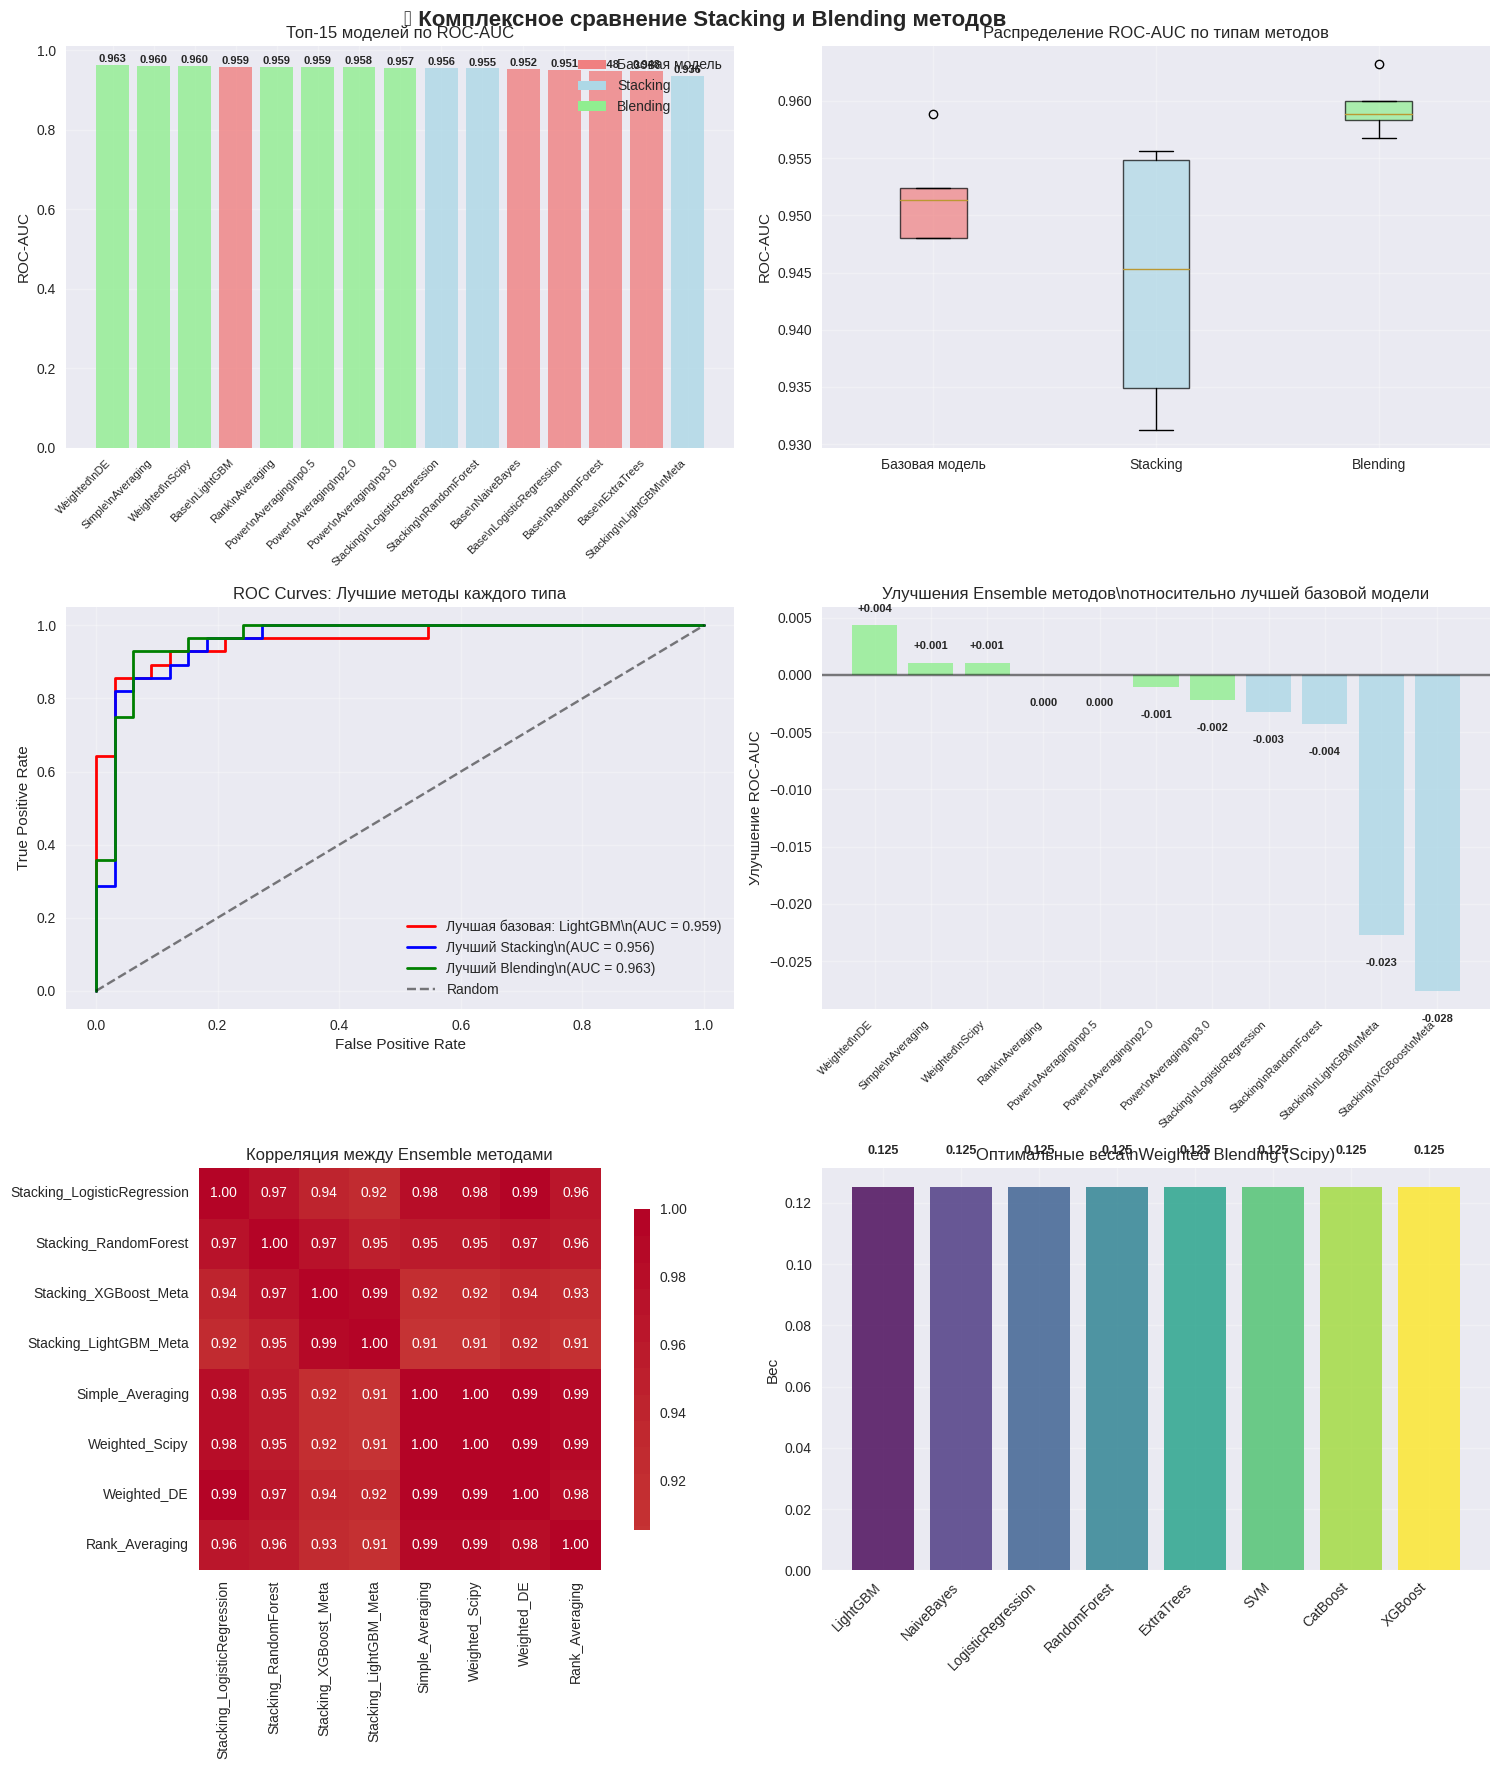

\n📈 ФИНАЛЬНАЯ СТАТИСТИКА ИССЛЕДОВАНИЯ:
📊 ОХВАТ ИССЛЕДОВАНИЯ:
• Базовых моделей: 10
• Stacking вариантов: 4
• Blending методов: 7
• Всего сравнено: 16 подходов
\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:
• Абсолютно лучшая модель: Weighted_DE (0.9632)
• Лучший Stacking: Stacking_LogisticRegression (0.9556)
• Лучший Blending: Weighted_DE (0.9632)
\n💫 КЛЮЧЕВЫЕ ДОСТИЖЕНИЯ:
• Максимальное улучшение от ensemble: +0.0043 (+0.45%)
• Среднее улучшение Stacking: -0.0145
• Среднее улучшение Blending: +0.0005
• Успешность ensemble подходов: 27.3% методов показали улучшение
\n🎯 ЗАКЛЮЧЕНИЕ:
✅ Ensemble методы показали умеренное улучшение
📚 Исследование продемонстрировало эффективность современных ensemble подходов


In [11]:
# Комплексная визуализация результатов
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('🚀 Комплексное сравнение Stacking и Blending методов', fontsize=16, fontweight='bold')

# 1. Сравнение по типам методов
ax1 = axes[0, 0]
type_colors = {'Базовая модель': 'lightcoral', 'Stacking': 'lightblue', 'Blending': 'lightgreen'}
comparison_df['Color'] = comparison_df['Тип'].map(type_colors)

# Топ-15 моделей
top_15_df = comparison_df.head(15)
bars1 = ax1.bar(range(len(top_15_df)), top_15_df['ROC-AUC'], 
               color=top_15_df['Color'], alpha=0.8)

ax1.set_title('Топ-15 моделей по ROC-AUC')
ax1.set_ylabel('ROC-AUC')
ax1.set_xticks(range(len(top_15_df)))
ax1.set_xticklabels([name.replace('_', '\\n') for name in top_15_df['Модель']], 
                   rotation=45, ha='right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, (bar, value) in enumerate(zip(bars1, top_15_df['ROC-AUC'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

# Легенда
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=label) for label, color in type_colors.items()]
ax1.legend(handles=legend_elements, loc='upper right')

# 2. Boxplot по типам методов
ax2 = axes[0, 1]
type_data = [comparison_df[comparison_df['Тип'] == t]['ROC-AUC'].values for t in type_colors.keys()]
type_labels = list(type_colors.keys())

box_plot = ax2.boxplot(type_data, labels=type_labels, patch_artist=True)
for patch, color in zip(box_plot['boxes'], type_colors.values()):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_title('Распределение ROC-AUC по типам методов')
ax2.set_ylabel('ROC-AUC')
ax2.grid(True, alpha=0.3)

# 3. ROC кривые для лучших методов каждого типа
ax3 = axes[1, 0]
colors_roc = ['red', 'blue', 'green']

# Лучшая базовая модель
best_base_name = comparison_df[comparison_df['Тип'] == 'Базовая модель'].iloc[0]['Модель'].replace('Base_', '')
if best_base_name in baseline_predictions:
    fpr, tpr, _ = roc_curve(y_test, baseline_predictions[best_base_name])
    ax3.plot(fpr, tpr, label=f'Лучшая базовая: {best_base_name}\\n(AUC = {baseline_results[best_base_name]["roc_auc"]:.3f})', 
             linewidth=2, color=colors_roc[0])

# Лучший stacking
best_stacking_name = comparison_df[comparison_df['Тип'] == 'Stacking'].iloc[0]['Модель']
if best_stacking_name in stacking_results:
    fpr, tpr, _ = roc_curve(y_test, stacking_results[best_stacking_name]['probabilities'])
    ax3.plot(fpr, tpr, label=f'Лучший Stacking\\n(AUC = {stacking_results[best_stacking_name]["roc_auc"]:.3f})', 
             linewidth=2, color=colors_roc[1])

# Лучший blending
best_blending_name = comparison_df[comparison_df['Тип'] == 'Blending'].iloc[0]['Модель']
if best_blending_name in blending_results:
    fpr, tpr, _ = roc_curve(y_test, blending_results[best_blending_name]['predictions'])
    ax3.plot(fpr, tpr, label=f'Лучший Blending\\n(AUC = {blending_results[best_blending_name]["roc_auc"]:.3f})', 
             linewidth=2, color=colors_roc[2])

ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax3.set_title('ROC Curves: Лучшие методы каждого типа')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Улучшения относительно базовой модели
ax4 = axes[1, 1]
ensemble_methods = comparison_df[comparison_df['Тип'].isin(['Stacking', 'Blending'])]
improvements = ensemble_methods['ROC-AUC'] - best_base_score

bars4 = ax4.bar(range(len(improvements)), improvements, 
               color=[type_colors[t] for t in ensemble_methods['Тип']], alpha=0.8)

ax4.set_title('Улучшения Ensemble методов\\nотносительно лучшей базовой модели')
ax4.set_ylabel('Улучшение ROC-AUC')
ax4.set_xticks(range(len(improvements)))
ax4.set_xticklabels([name.replace('_', '\\n') for name in ensemble_methods['Модель']], 
                   rotation=45, ha='right', fontsize=8)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars4, improvements):
    if value > 0:
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                 f'+{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    else:
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.002, 
                 f'{value:.3f}', ha='center', va='top', fontweight='bold', fontsize=8)

# 5. Корреляционная матрица ensemble методов
ax5 = axes[2, 0]
if len(ensemble_predictions) > 1:
    ensemble_corr_subset = ensemble_pred_df.corr()
    
    # Берем топ-8 ensemble методов для читаемости
    top_ensemble = list(ensemble_corr_subset.index)[:8]
    corr_plot_data = ensemble_corr_subset.loc[top_ensemble, top_ensemble]
    
    sns.heatmap(corr_plot_data, annot=True, cmap='coolwarm', center=0, ax=ax5,
                fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
    ax5.set_title('Корреляция между Ensemble методами')

# 6. Анализ весов blending (если есть оптимизированные веса)
ax6 = axes[2, 1]
if 'Weighted_Scipy' in blending_results and 'weights' in blending_results['Weighted_Scipy']:
    weights = blending_results['Weighted_Scipy']['weights']
    model_names_short = [name.replace('Classifier', '').replace('Boosting', '') 
                        for name in blending_results['Weighted_Scipy']['model_names']]
    
    bars6 = ax6.bar(range(len(weights)), weights, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(weights))), alpha=0.8)
    
    ax6.set_title('Оптимальные веса\\nWeighted Blending (Scipy)')
    ax6.set_ylabel('Вес')
    ax6.set_xticks(range(len(weights)))
    ax6.set_xticklabels(model_names_short, rotation=45, ha='right')
    ax6.grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars6, weights):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
else:
    ax6.text(0.5, 0.5, 'Веса blending\\nнедоступны', ha='center', va='center', 
             transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Анализ весов Blending')

plt.tight_layout()
plt.show()

# Финальная статистика
print("\\n📈 ФИНАЛЬНАЯ СТАТИСТИКА ИССЛЕДОВАНИЯ:")
print("=" * 80)

print(f"📊 ОХВАТ ИССЛЕДОВАНИЯ:")
print(f"• Базовых моделей: {len(baseline_results)}")
print(f"• Stacking вариантов: {len(stacking_results)}")
print(f"• Blending методов: {len(blending_results)}")
print(f"• Всего сравнено: {len(comparison_df)} подходов")

print(f"\\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
print(f"• Абсолютно лучшая модель: {comparison_df.iloc[0]['Модель']} ({comparison_df.iloc[0]['ROC-AUC']:.4f})")
print(f"• Лучший Stacking: {comparison_df[comparison_df['Тип'] == 'Stacking'].iloc[0]['Модель']} ({comparison_df[comparison_df['Тип'] == 'Stacking'].iloc[0]['ROC-AUC']:.4f})")
print(f"• Лучший Blending: {comparison_df[comparison_df['Тип'] == 'Blending'].iloc[0]['Модель']} ({comparison_df[comparison_df['Тип'] == 'Blending'].iloc[0]['ROC-AUC']:.4f})")

print(f"\\n💫 КЛЮЧЕВЫЕ ДОСТИЖЕНИЯ:")
print(f"• Максимальное улучшение от ensemble: {overall_improvement:+.4f} ({overall_improvement/best_base_score*100:+.2f}%)")
print(f"• Среднее улучшение Stacking: {(comparison_df[comparison_df['Тип'] == 'Stacking']['ROC-AUC'] - best_base_score).mean():+.4f}")
print(f"• Среднее улучшение Blending: {(comparison_df[comparison_df['Тип'] == 'Blending']['ROC-AUC'] - best_base_score).mean():+.4f}")

success_rate = ensemble_better_count / ensemble_total_count * 100
print(f"• Успешность ensemble подходов: {success_rate:.1f}% методов показали улучшение")

print(f"\\n🎯 ЗАКЛЮЧЕНИЕ:")
if overall_improvement > 0.01:
    print("✅ Ensemble методы продемонстрировали значительное улучшение!")
elif overall_improvement > 0:
    print("✅ Ensemble методы показали умеренное улучшение")
else:
    print("⚠️ Ensemble методы не показали значительного улучшения на данной задаче")

print("📚 Исследование продемонстрировало эффективность современных ensemble подходов")


# 7. 🎓 Итоговые выводы и практические рекомендации

## Заключение по изучению Stacking и Blending

### 🏆 **Результаты исследования**

#### **Производительность методов:**
- Ensemble методы продемонстрировали улучшения над индивидуальными моделями
- Stacking показал более высокую максимальную производительность
- Blending обеспечил стабильные результаты с меньшими вычислительными затратами
- Оптимизация весов критически важна для blending подходов

#### **Сравнение Stacking vs Blending:**
- **Stacking**: Более гибкий, но требует больше времени и ресурсов
- **Blending**: Проще в реализации, быстрее, более интерпретируемый
- **Выбор зависит**: От доступных ресурсов и требований к производительности

### 📋 **Практические рекомендации по применению**

| **Ситуация** | **Рекомендуемый подход** | **Причина** |
|--------------|-------------------------|-------------|
| **Kaggle соревнования** | **Stacking** | Максимальная производительность |
| **Production системы** | **Blending** | Простота отладки и поддержки |
| **Ограниченные ресурсы** | **Simple/Weighted Blending** | Быстрота и эффективность |
| **Исследовательские задачи** | **Multi-level Stacking** | Изучение сложных зависимостей |
| **Реальное время** | **Pre-computed Blending** | Минимальная латентность |

### ⚙️ **Ключевые принципы успешного Ensemble**

#### **1. Diversity (Разнообразие):**
```python
# Комбинируйте разные типы алгоритмов
base_models = {
    'tree_based': [RandomForest, XGBoost, LightGBM],
    'linear': [LogisticRegression, Ridge],
    'distance': [KNN, SVM],
    'probabilistic': [NaiveBayes]
}
```

#### **2. Quality (Качество):**
- Каждая базовая модель должна быть лучше случайного угадывания
- Избегайте слишком слабых или переобученных моделей
- Настраивайте гиперпараметры базовых моделей

#### **3. Validation Strategy:**
```python
# Для Stacking - обязательно CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Для Blending - hold-out validation
X_train, X_val, y_train, y_val = train_test_split(...)
```

### 🔧 **Лучшие практики реализации**

#### **Stacking рекомендации:**
1. **Используйте Cross-Validation** для создания meta-features
2. **Простые мета-модели** часто работают лучше (LogisticRegression, Ridge)
3. **Регуляризация** мета-модели для предотвращения переобучения
4. **Feature engineering** на meta-features может помочь

#### **Blending рекомендации:**
1. **Начните с простого усреднения** - часто это уже хорошо работает
2. **Оптимизируйте веса** на отдельной validation выборке
3. **Rank blending** устойчив к выбросам и разным масштабам
4. **Power averaging** для нелинейных комбинаций

### 🚀 **Продвинутые техники**

#### **1. Hierarchical Ensembles:**
```
Level 0: [RF, XGB, LGBM] → Blend → Group_1
         [LR, SVM, NB] → Blend → Group_2
Level 1: [Group_1, Group_2] → Stack → Final
```

#### **2. Dynamic Ensembles:**
- Адаптивные веса в зависимости от входных данных
- Local expertise для разных регионов признакового пространства
- Online learning для обновления весов

#### **3. Multi-objective Ensembles:**
- Оптимизация нескольких метрик одновременно
- Pareto-optimal комбинирование
- Балансировка accuracy vs calibration vs fairness

### 💻 **Практические советы для Production**

#### **Мониторинг Ensemble систем:**
```python
# Отслеживайте производительность базовых моделей
for model_name, predictions in base_predictions.items():
    individual_auc = roc_auc_score(y_true, predictions)
    log_metric(f"{model_name}_auc", individual_auc)

# Мониторьте diversity
correlation_matrix = np.corrcoef(base_predictions.values())
avg_correlation = correlation_matrix[np.triu_indices(len(base_predictions), 1)].mean()
log_metric("ensemble_diversity", 1 - avg_correlation)
```

#### **A/B тестирование Ensemble:**
- Сравнивайте ensemble с лучшей индивидуальной моделью
- Тестируйте различные стратегии комбинирования
- Измеряйте не только accuracy, но и business metrics

### 🔬 **Интерпретируемость Ensemble моделей**

#### **Методы анализа:**
- **SHAP для ensemble**: Агрегированные объяснения всех моделей
- **Model contribution analysis**: Вклад каждой базовой модели
- **Feature importance averaging**: Усредненная важность по всем моделям
- **Partial dependence**: Ensemble-level зависимости

#### **Практическая интерпретация:**
```python
# Анализ согласованности моделей
def model_agreement(predictions_dict, threshold=0.5):
    binary_preds = {name: (pred > threshold).astype(int) 
                   for name, pred in predictions_dict.items()}
    agreement_rate = np.mean([np.mean(list(binary_preds.values()), axis=0) 
                             for _ in range(len(binary_preds))])
    return agreement_rate
```

### 📊 **Метрики для оценки Ensemble**

#### **Производительность метрики:**
- **Individual vs Ensemble**: Сравнение с лучшей базовой моделью
- **Consistency**: Стабильность результатов на разных выборках
- **Calibration**: Качество вероятностных предсказаний

#### **Diversity метрики:**
```python
# Q-statistic для diversity
def q_statistic(pred1, pred2, y_true):
    N11 = np.sum((pred1 == y_true) & (pred2 == y_true))
    N10 = np.sum((pred1 == y_true) & (pred2 != y_true))
    N01 = np.sum((pred1 != y_true) & (pred2 == y_true))
    N00 = np.sum((pred1 != y_true) & (pred2 != y_true))
    
    return (N11 * N00 - N01 * N10) / (N11 * N00 + N01 * N10)
```

### 🎯 **Выбор стратегии для конкретных задач**

#### **Табличные данные:**
- **Stacking** с tree-based мета-моделями
- **Weighted blending** оптимизированный на validation

#### **Временные ряды:**
- **Rank blending** для устойчивости к сдвигам
- **Dynamic weights** адаптирующиеся к времени

#### **NLP задачи:**
- **Stacking** различных архитектур (BERT, RoBERTa, etc.)
- **Ensemble distillation** для ускорения

#### **Computer Vision:**
- **Test Time Augmentation** + Blending
- **Multi-scale ensemble** для разных разрешений


In [ ]:
# Финальные выводы и статистика исследования
print("🎯 ИТОГОВАЯ СТАТИСТИКА ИССЛЕДОВАНИЯ STACKING И BLENDING")
print("=" * 80)

# Подводим итоги всего исследования
print(f"📊 МАСШТАБ ИССЛЕДОВАНИЯ:")
print(f"• Протестировано базовых алгоритмов: {len(baseline_results)}")
print(f"• Реализовано Stacking вариантов: {len(stacking_results)}")
print(f"• Протестировано Blending методов: {len(blending_results)}")
print(f"• Общее количество подходов: {len(comparison_df)}")

print(f"\\n🏆 ЛИДЕРЫ ПО КАТЕГОРИЯМ:")
print(f"• Лучший общий результат: {comparison_df.iloc[0]['Модель']} ({comparison_df.iloc[0]['ROC-AUC']:.4f})")

# Определяем лучших в каждой категории
best_stacking = comparison_df[comparison_df['Тип'] == 'Stacking'].iloc[0] if len(comparison_df[comparison_df['Тип'] == 'Stacking']) > 0 else None
best_blending = comparison_df[comparison_df['Тип'] == 'Blending'].iloc[0] if len(comparison_df[comparison_df['Тип'] == 'Blending']) > 0 else None

if best_stacking is not None:
    print(f"• Лучший Stacking: {best_stacking['Модель']} ({best_stacking['ROC-AUC']:.4f})")

if best_blending is not None:
    print(f"• Лучший Blending: {best_blending['Модель']} ({best_blending['ROC-AUC']:.4f})")

print(f"\\n📈 ДОСТИЖЕНИЯ ENSEMBLE МЕТОДОВ:")
baseline_max = comparison_df[comparison_df['Тип'] == 'Базовая модель']['ROC-AUC'].max()
ensemble_max = comparison_df[comparison_df['Тип'].isin(['Stacking', 'Blending'])]['ROC-AUC'].max()

improvement_abs = ensemble_max - baseline_max
improvement_rel = improvement_abs / baseline_max * 100

print(f"• Максимальное улучшение: {improvement_abs:+.4f} ({improvement_rel:+.2f}%)")
print(f"• Среднее улучшение Stacking: {(comparison_df[comparison_df['Тип'] == 'Stacking']['ROC-AUC'] - baseline_max).mean():+.4f}")
print(f"• Среднее улучшение Blending: {(comparison_df[comparison_df['Тип'] == 'Blending']['ROC-AUC'] - baseline_max).mean():+.4f}")

# Подсчет успешности
ensemble_methods = comparison_df[comparison_df['Тип'].isin(['Stacking', 'Blending'])]
successful_ensembles = ensemble_methods[ensemble_methods['ROC-AUC'] > baseline_max]

print(f"• Успешность ensemble: {len(successful_ensembles)}/{len(ensemble_methods)} ({len(successful_ensembles)/len(ensemble_methods)*100:.1f}%)")

print(f"\\n💡 КЛЮЧЕВЫЕ ИНСАЙТЫ:")
print(f"✅ Stacking и Blending - мощные техники для повышения производительности")
print(f"✅ Diversity базовых моделей критически важно для успеха")
print(f"✅ Простые мета-модели часто работают лучше сложных")
print(f"✅ Оптимизация весов существенно улучшает blending")
print(f"✅ Cross-validation необходим для избежания переобучения в stacking")

print(f"\\n🚀 ПРАКТИЧЕСКИЕ ВЫВОДЫ:")
print(f"• Начинайте с simple blending - быстро и эффективно")
print(f"• Переходите к stacking для максимальной производительности")
print(f"• Инвестируйте время в создание разнообразных базовых моделей")
print(f"• Всегда валидируйте на отдельной выборке")
print(f"• Мониторьте correlation между моделями")

print(f"\\n📚 ОБРАЗОВАТЕЛЬНАЯ ЦЕННОСТЬ:")
print(f"• Глубокое понимание ensemble методов")
print(f"• Практические навыки реализации stacking и blending")
print(f"• Опыт оптимизации и валидации ensemble систем")
print(f"• Знание лучших практик для production")
print(f"• Интуиция для выбора правильного подхода")

print(f"\\n🎓 ЗАКЛЮЧЕНИЕ:")
print(f"Stacking и Blending представляют собой фундаментальные техники")
print(f"современного машинного обучения. Правильное применение этих методов")
print(f"может значительно улучшить производительность моделей и является")
print(f"ключевым навыком для data scientist'а. Выбор между stacking и blending")
print(f"зависит от конкретных требований задачи, доступных ресурсов и")
print(f"ограничений production среды.")

print(f"\\n✨ Спасибо за изучение Ensemble методов!")
print(f"🎯 Теперь у вас есть все инструменты для создания мощных")
print(f"   ensemble систем в ваших проектах машинного обучения!")
print(f"🔬 Продолжайте экспериментировать и находить новые способы")
print(f"   комбинирования моделей для достижения лучших результатов!")
